# What is my old car worth?

Following the extension of the family, we decided to buy a new, bigger, car, and hence to sell our old car (an Audi A3 sportsback). There exists online ressources to evaluate the price of used cars on the market (Eurotax for the swiss market), but I thought it was an interesting data science case to evaluate myself the price of my car based on the market.

The adopted strategy consists into 3 steps:
- first acquire some data online including the price and the car characteristics
- build a pricing model using machine learning
- evaluate the price of my car given its characteristics

In addition, it will be interesting to see if Eurotax and the market agree with each other. My guess is that the market should be close to but slightly more expensive than Eurotax, because people tend to overestimate the price of their goods when selling them.

## Preamble

As usual we import the necessary libraries.

In [2]:
# system libraries
import os
import sys
import re
from datetime import date, datetime, timedelta
import numpy as np

# for data handling
import pandas as pd

# for web scraping
import requests
from bs4 import BeautifulSoup

# for plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
plt.rc('pdf',fonttype=42)

import seaborn as sns
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context(
    'notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})


## Data acquisition

To obtain the data I need, I get the data from a swiss selling items web site, focusing on the used car ads. I had several choices but I found one site that was relatively easy to analyse while having many ads (about 200k used car ads).

As usual the goal is to find the best compromise between getting as much data as possible while saving ressources in time and computing power (from both sides of the server and the client). The approach I choose is to get the data from the ad preview, which already contains the most critical pieces of information (such as car model, price, age and kilometers).

In [ ]:
# see Anibis scraping

## Data exploration

The scraping has been done twice. The first time on June 22nd and one week later. The goal is to see which typical ads have disappeared in the interval (i.e. if they were sold rapidely).

### Import data

In [113]:
# read csv files
df_1 = pd.read_csv('22.06.2019_all.csv', index_col='item_id')
df_2 = pd.read_csv('29.06.2019_all.csv', index_col='item_id')

# merge the two
df_ads = df_1.join(
    df_2['age_ad_days'], rsuffix='_2', how='left', on='item_id')

# create a new column: True if it disa
select = df_ads['age_ad_days_2'].isnull()
df_ads['less_than_a_week'] = select
df_ads = df_ads.drop('age_ad_days_2', axis=1)

# Display numbers
print('Total: {0}. Disappeared in 1 week: {1}'.format(len(df_ads), sum(select)))

Total: 232642. Disappeared in 1 week: 16415


In [8]:
df_ads.head()

,date,description,engine,km,link,location,name,price,year,brand,model,model details,age_car_years,age_ad_days,less_than_a_week
item_id,,,,,,,,,,,,,,,
29510324,2019-06-17,\n*FAHRZEUG IN GUTEN ZUSTAND* *SERVICE GEPFLEG...,Diesel,176000.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Wetzikon,AUDI A6 Avant 2.7 V6 TDI,5500.0,2008-01-01,AUDI,A6,Avant,11.501370,13.0,True
29510323,2019-06-17,\nAusstattung:AlufelgenManuelle KlimaanlageEin...,Essence,78300.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Ringgenberg,BMW X1 xDrive 20i Steptronic,19800.0,2014-01-01,BMW,X1,xDrive,5.495890,13.0,True
29510305,2019-06-17,\nA vendre belle BMW 325xi en excellent état.L...,Essence,134000.0,https://www.anibis.ch//fr/d-automobiles-voitur...,L'Auberson,"BMW 325xi, 2007, 134'000 km",10000.0,2007-01-01,BMW,"325xi,","2007,",12.501370,13.0,False
29510302,2019-06-17,"\nHonda civic 1,4 90 cvUne portière est légére...",Essence,205000.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Dombresson,"Honda civic, 2000, 205'000 km",1200.0,2000-01-01,Honda,"civic,","2000,",19.506849,13.0,False
29510298,2019-06-17,\nBesichtigung und Probefahrt jeder Zwit mögli...,Essence,197490.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Grub AR,"Ford Fiesta, 2008, 197'490 km",2900.0,2008-01-01,Ford,"Fiesta,","2008,",11.501370,13.0,False


### Cleaning

We take a quick look at the data and clean what's necessary. Here we see that a number of ads are over 1000 days old and some have no valid date. This may correspond to promoted ads. We remove them. We also remove prices over CHF 1M. 

Identically, some ads have a very high number of kilometers.

In total we get rid of 36% of ads.

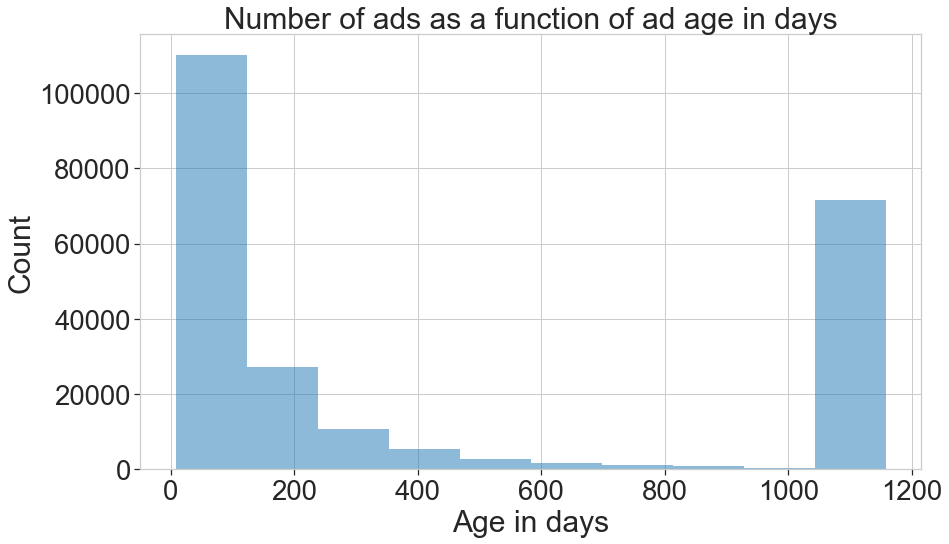

In [30]:
fig, ax = plt.subplots()

ax.hist(
    df_ads['age_ad_days'].dropna(), alpha=0.5, 
    label='All', density=False) #, bins=np.linspace(10,50))
ax.set_xlabel('Age in days')
ax.set_ylabel('Count')
ax.set_title('Number of ads as a function of ad age in days')

None

In [59]:
# cleaning
select = df_ads['age_ad_days'] > 0
select &= df_ads['age_ad_days'] < 1000
select &= df_ads['price'] < 1.e6
select &= df_ads['price'] > 0
select &= df_ads['km'] > 0
select &= df_ads['km'] < 2.e5
df_ads_clean = df_ads[select]

# how much is dropped?
N = len(df_ads)
N_clean = len(df_ads_clean)

#(len(df_ads)-len(df_ads_clean))/len(df_ads)

print('N: {}, N(clean): {} , dropped fraction: {:.2f}%'.format(
    N, N_clean, 100.*(N-N_clean)/N))

N: 232642, N(clean): 149590 , dropped fraction: 35.70%


In [68]:
df_ads_clean.head()

,date,description,engine,km,link,location,name,price,year,brand,model,model details,age_car_years,age_ad_days,less_than_a_week
item_id,,,,,,,,,,,,,,,
29510324,2019-06-17,\n*FAHRZEUG IN GUTEN ZUSTAND* *SERVICE GEPFLEG...,Diesel,176000.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Wetzikon,AUDI A6 Avant 2.7 V6 TDI,5500.0,2008-01-01,AUDI,A6,Avant,11.501370,13.0,True
29510323,2019-06-17,\nAusstattung:AlufelgenManuelle KlimaanlageEin...,Essence,78300.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Ringgenberg,BMW X1 xDrive 20i Steptronic,19800.0,2014-01-01,BMW,X1,xDrive,5.495890,13.0,True
29510305,2019-06-17,\nA vendre belle BMW 325xi en excellent état.L...,Essence,134000.0,https://www.anibis.ch//fr/d-automobiles-voitur...,L'Auberson,"BMW 325xi, 2007, 134'000 km",10000.0,2007-01-01,BMW,"325xi,","2007,",12.501370,13.0,False
29510298,2019-06-17,\nBesichtigung und Probefahrt jeder Zwit mögli...,Essence,197490.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Grub AR,"Ford Fiesta, 2008, 197'490 km",2900.0,2008-01-01,Ford,"Fiesta,","2008,",11.501370,13.0,False
29510297,2019-06-17,\nFerrari Mondial F 108 AL/Quattrovalvole – 19...,Essence,92200.0,https://www.anibis.ch//fr/d-automobiles-voitur...,Genève,"Ferrari Mondial, 1983, 92'200 km",39500.0,1983-01-01,Ferrari,"Mondial,","1983,",36.517808,13.0,False


## Price distribution

The price is our target to estimate. We take a look at its distribtution. Interstingly, the price distribution is roughly log-normal, i.e. the logarithm of is normal, and hence skewed towards higher values. The median price is CHF 28'800.

24800.0


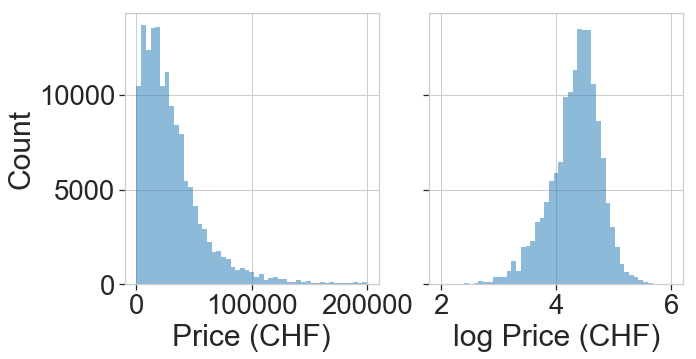

In [116]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax[0].hist(
    df_ads_clean['price'], alpha=0.5, 
    label='All', bins=np.linspace(0,2.e5))
ax[0].set_xlabel('Price (CHF)')
ax[0].set_ylabel('Count')

ax[1].hist(
    np.log10(df_ads_clean['price']), alpha=0.5, 
    label='All', bins=np.linspace(2,6))

ax[1].set_xlabel('log Price (CHF)')

print(df_ads_clean['price'].median())

None

## Features

Next, we explore here the distribution of features and the correlation between them. First we pick a number of features and see how the price depends on them, then we look at the distribution of the features. 

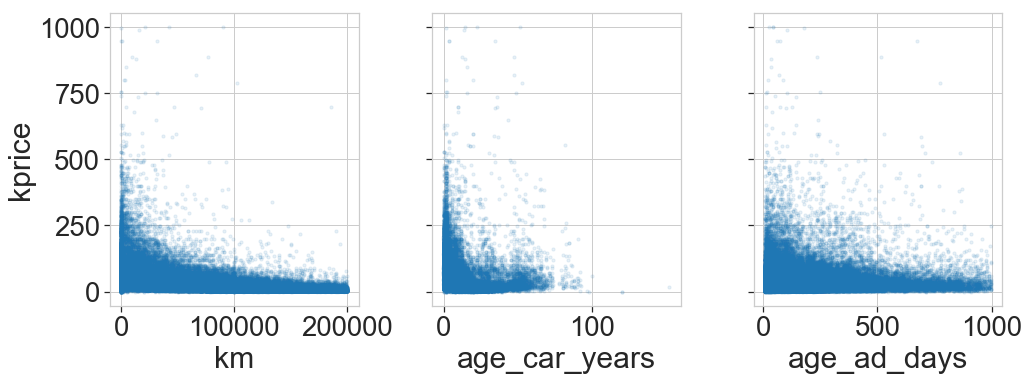

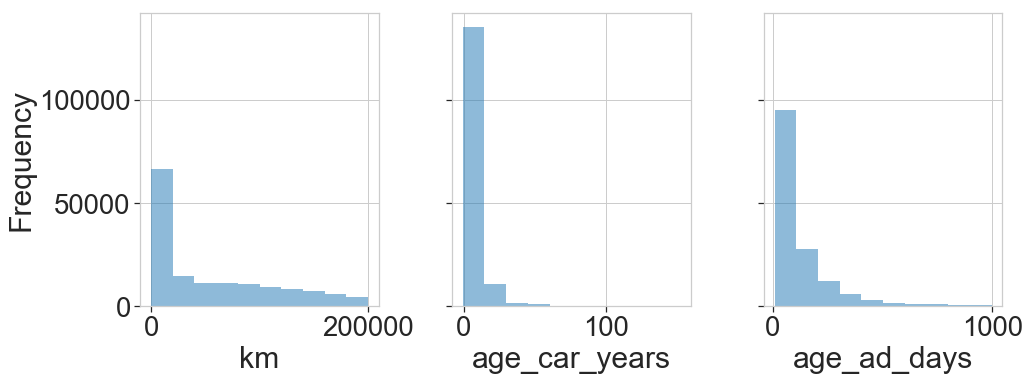

In [117]:
attributes = ['km', 'age_car_years',  'age_ad_days']
# fig, ax = plt.subplots(figsize=(4,4))
n_i, n_j = 1, 3
fig, ax = plt.subplots(
    n_i, n_j, figsize=(15, 6), sharey = True)
# plot price vs attribute
for k, a in enumerate(attributes):
    df_ads_clean.plot.scatter(
        x=a, y='kprice',
        ax=ax[k], 
        s=10, alpha=0.1)
fig.tight_layout()

fig, ax = plt.subplots(
    n_i, n_j, figsize=(15, 6), sharey = True)
    
# plot price vs attribute
for k, a in enumerate(attributes):
    df_ads_clean[a].plot.hist(
        ax=ax[k], alpha=0.5, logy=False)
    ax[k].set_xlabel(a)

fig.tight_layout()

# ax=ax[k%n_i, k//n_i],
# do not plot axes with no data
#for k in range(len(attributes),n_i*n_j ):
#    ax[k%n_i, k//n_i].axis('off')


None

Most cars have few kilometers and are relatively new. As expected the price increases with low km and small age.

## Audi A3

We will now focus on a specific model, i.e. the one we attempt to model the price, an Audi A3.

### Selection of the car model

We apply a number of filters on the brand, model and model details. As the text form is free, we are flexible in the search term. 

In [129]:
# Brand and model
select = df_ads_clean['brand'].fillna('').str.contains('Audi|AUDI|audi')
select &= df_ads_clean['model'].fillna('').str.contains('A3|a3')

# Select specifically the sportsback (5 doors) models
select &= \
    df_ads_clean['model details'].fillna('').str.contains('Sportback|sportback')\
    |df_ads_clean['description'].fillna('').str.contains('Sportback|sportback')\
    |df_ads_clean['name'].fillna('').str.contains('Sportback|sportback')

# Engine type 
select &= \
    df_ads_clean['model details'].fillna('').str.contains('TDI')\
    |df_ads_clean['description'].fillna('').str.contains('TDI')\
    |df_ads_clean['name'].fillna('').str.contains('TDI')

# We exclude new cars
#select &= df_ads_clean['km'] > 1000.

df_Audi_A3 = df_ads_clean[select]

print(sum(select))

285


### features

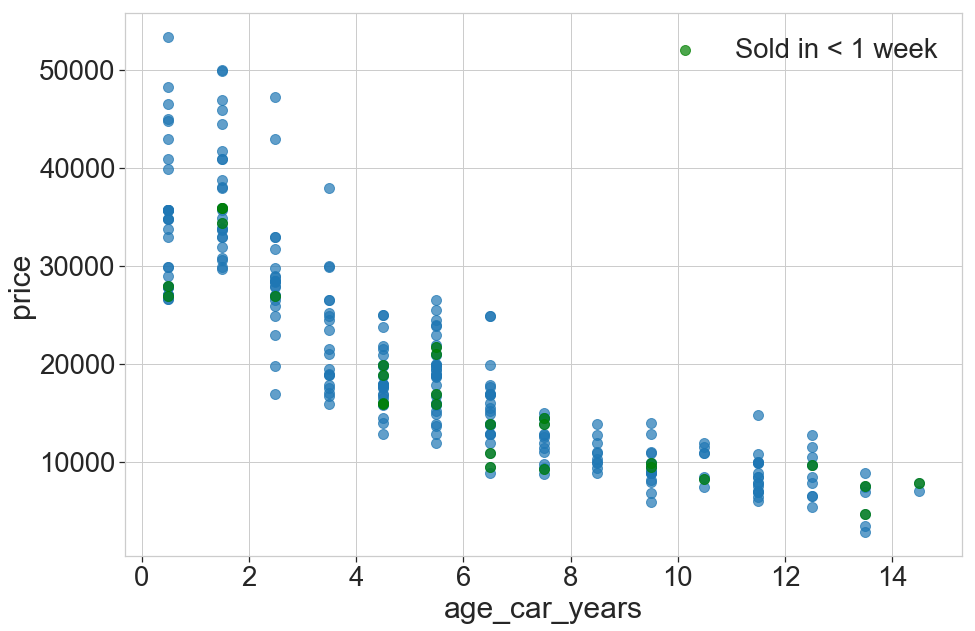

In [130]:
fig, ax = plt.subplots(figsize=(15,10))

df_Audi_A3.plot.scatter(
    marker='o', x='age_car_years', y='price', ax=ax, s=100, alpha=0.7)

select = df_Audi_A3['less_than_a_week']
if select.any():
    df_Audi_A3[select].plot.scatter(
        x='age_car_years', y='price', ax=ax, s=100, alpha=0.7,
        marker='o', c='green', label='Sold in < 1 week')


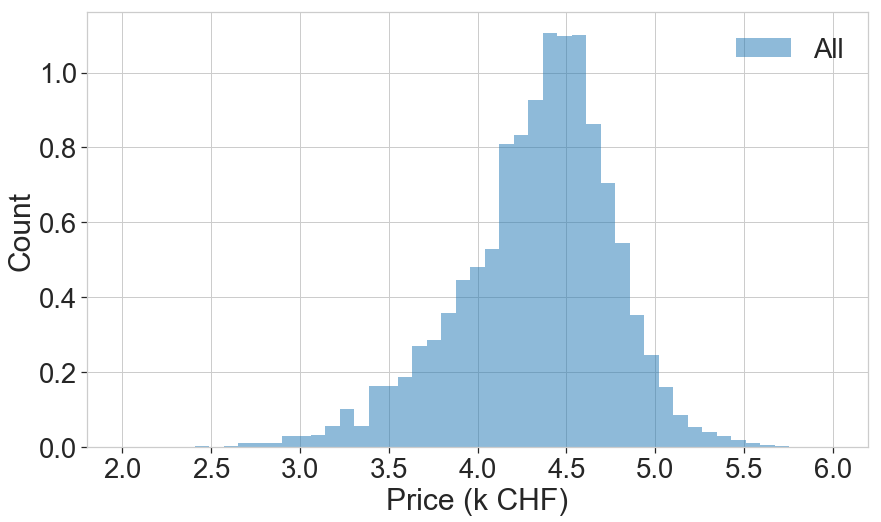

In [77]:
fig, ax = plt.subplots()


ax.hist(
    np.log10(df_ads_clean['price']), alpha=0.5, 
    label='All', density=True, bins=np.linspace(2,6))

ax.set_xlabel('Price (k CHF)')
ax.set_ylabel('Count')

ax.legend()

None

In [ ]:
df.head()

In [ ]:
# model dictionary
models = {}

## Select ads that disapeared in 1 week

In [ ]:
# cleaning
select = df['age_ad_days'] > 0
select &= df['age_ad_days'] < 1000
select &= df['price'] < 1.e6
df = df[select]

df['log_age_car_years'] = df['age_car_years'].apply(np.log10)
df['log_km'] = df['km'].apply(np.log10)

In [ ]:
fig, ax = plt.subplots()

select = df['less_than_a_week'] == True
df[select]

select = df['price'] < 1.5e4
select &= df['price'] > 0.0

ax.hist(df['price'][select], alpha=0.5, label='All', density=True) #, bins=np.linspace(10,50))

select = df['price'] < 1.5e4
select &= df['price'] > 0.0
select &= df['less_than_a_week'] == True

ax.hist(df['price'][select], alpha=0.5, label='< 1 week', density=True) #, bins=np.linspace(10,50))

None

In [ ]:
fig, ax = plt.subplots()

select = df['less_than_a_week'] == True
df[select]

select = df['log_km'] < 1.5e5
select &= df['log_km'] > 0.0

ax.hist(df['log_km'][select], alpha=0.5, label='All', density=True) #, bins=np.linspace(10,50))

select = df['log_km'] < 1.5e5
select &= df['log_km'] > 0.0
select &= df['less_than_a_week'] == True

ax.hist(df['log_km'][select], alpha=0.5, label='< 1 week', density=True) #, bins=np.linspace(10,50))

None

## Transformation

In [ ]:
df['log_age_car_years'] = df['age_car_years'].apply(np.log10)
df['log_km'] = df['km'].apply(np.log10)

## Select all Audi A3 sportback TDI

In [ ]:
select = df['brand'].fillna('').str.contains('Audi|AUDI|audi')
select &= df['model'].fillna('').str.contains('A3|a3')
select &= \
    df['model details'].fillna('').str.contains('Sportback|sportback')\
    |df['description'].fillna('').str.contains('Sportback|sportback')\
    |df['name'].fillna('').str.contains('Sportback|sportback')
select &= \
    df['model details'].fillna('').str.contains('TDI')\
    |df['description'].fillna('').str.contains('TDI')\
    |df['name'].fillna('').str.contains('TDI')

# exclude new cars
select &= df['km'] > 1000.

models['Audi A3 Sportback_TDI'] = df[select]

print(sum(select))

In [ ]:
# models['Audi A3 Sportback_TDI'].head()

## Price modeling

Take into account age and kilometers

In [ ]:
# are there any ad that disapeared after 1 week?
select =  models['Audi A3 Sportback_TDI']['less_than_a_week'] == True
sum(select)

### Price distribution

In [ ]:
fig, ax = plt.subplots()


ax.hist(models['Audi A3 Sportback_TDI']['price']/1.e3, alpha=0.5, label='All', density=True) #, bins=np.linspace(10,50))
select =  models['Audi A3 Sportback_TDI']['less_than_a_week'] == True
ax.hist(models['Audi A3 Sportback_TDI'][select]['price']/1.e3, alpha=0.5, label='< 1 week', density=True) #, bins=np.linspace(10,50))

#ax[0].hist(df_2010['Age'], alpha=0.5, label='2018', density=True) #, bins=np.linspace(10,50))

ax.set_xlabel('Price (k CHF)')
ax.set_ylabel('Count')

ax.legend()

None

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

select =  models['Audi A3 Sportback_TDI']['km'] < 1.e5
models['Audi A3 Sportback_TDI'][select].plot.scatter(
    marker='o', x='log_age_car_years', y='price', ax=ax, s=100, alpha=0.7)

select =  models['Audi A3 Sportback_TDI']['km'] > 1.e5
models['Audi A3 Sportback_TDI'][select].plot.scatter(
    marker='o', x='log_age_car_years', y='price', ax=ax, s=100, alpha=0.7, c='red')

select =  models['Audi A3 Sportback_TDI']['less_than_a_week'] == True
if select.any():
    models['Audi A3 Sportback_TDI'][select].plot.scatter(
        x='log_age_car_years', y='price', ax=ax, s=100, alpha=0.7,
        marker='o', c='green', label='Sold in 1 week')

#models['Audi A3 Sportback_TDI'][select]['age_car_years']
#models['Audi A3 Sportback_TDI']['age_car_years']
    # ax.legend()

    #ax.set_ylim((10,1))
    #ax.scatter(ax.get_xlim(), [5,5], label = 'Top 5')

#y_test_predict = model.predict(X_test)

#ax.scatter(X_test['log_age_car_years'], y_test_predict, c='green', s=100, alpha=0.7)



In [ ]:
#?plt.scatter

In [ ]:
fig, ax = plt.subplots()

models['Audi A3 Sportback_TDI'].plot.scatter(
    x='log_km', y='price', figsize=(15,10), ax=ax, s=100, alpha=0.7)

#ax.set_xlim([3., 6.0])

select =  models['Audi A3 Sportback_TDI']['less_than_a_week'] == True
models['Audi A3 Sportback_TDI'].loc[select].plot.scatter(x='log_km', y='price', figsize=(15,10), ax=ax, c='green', s=100)

#y_test_predict = model.predict(X_test)

#ax.scatter(X_test['log_km'], y_test_predict, c='green', s=100, alpha=0.7)
#ax.set_xlabel('Years of experience')
#ax.set_ylabel('Salary')

In [ ]:
fig, ax = plt.subplots()

models['Audi A3 Sportback_TDI'].plot.scatter(
    x='age_car_years', y='km', figsize=(15,10), ax=ax, c='red', s=100, alpha=0.7)

# select =  models['Audi A3 Sportback_TDI']['less_than_a_week'] == True
# models['Audi A3 Sportback_TDI'].loc[select].plot.scatter(x='age_car_years', y='km', figsize=(15,10), ax=ax, c='green', s=100)

None

## Price prediction

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.neural_network import MLPRegressor

import xgboost as xgb


from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor



TODO
- evaluate errors (re-run 10x)
- test several models and compute MSE

In [ ]:
# functions
def split_data(X, y):
    """ Split the data assuming 
    training: 80%, test: 20% """
    
    X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(
        X, y, test_size=0.20)

    return X_train, X_test, y_train, y_test

def fit_data(model):
    
    return
    

In [ ]:
# perform multiple regression
df = models['Audi A3 Sportback_TDI']

attributes = ['log_age_car_years', 'log_km']

X = df[attributes]
y = df['price']

X_train, X_test, y_train, y_test = split_data(X, y)

model = LinearRegression(normalize=True, fit_intercept=True)
#model = LinearRegression(normalize=False, fit_intercept=True)
#model = svm.SVC()
#model = RandomForestRegressor()
#model = MLPRegressor()

model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)

## Audi price

In [ ]:
log_x = np.log10([13.0, 96000.])

log_x
model.predict([log_x])

#model.get_params()

In [ ]:
from sklearn import metrics

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))/1.e3

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))/1.e3

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))/1.e3